# create figures for HOT1A3 DE long term 

In [44]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

In [45]:
library(scales)

In [46]:
library(ggrepel)

In [47]:
status_palette <- c(
  "Up" = "#CC79A7",        # Green
  "Down" = "#009E73",      # Red
  "DE" = "#0072B2",      # Red
  "Unchanged" = "#e8ecec", # Gray
  "N/A" = "#bfc8c9"        # Light Yellow
)

In [48]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [49]:
df_all_orig = read_csv(file.path('..', 'Enrichment','DE_results', 'HOT1A3_all_FC_results.csv'))



Warning message:
"One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 101690 Columns: 36
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (24): contrast, protein_id, Assay, contrast1, seq_id, Name, gene, locus_...
dbl  (7): logFC, AveExpr, pvalue, padj, start, end, gene_length
lgl  (5): gene_synonym, exception, down, up, is_de

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [50]:
t(head(df_all_orig,2))

contrast,C2 - C1,C2 - C1
protein_id,WP_020744244.1,WP_061486834.1
logFC,1.536245,1.564814
AveExpr,0.8062054,0.4518796
pvalue,4.418240e-08,1.133719e-07
padj,9.826165e-05,1.260696e-04
Assay,Proteome,Proteome
contrast1,C2vsC1_prot,C2vsC1_prot
seq_id,NZ_CP012202.1,NZ_CP012202.1
Name,ACZ81_RS16015,ACZ81_RS19455
gene,"(mmsA,iolA)",NA


In [51]:
dput(sort(unique(df_all_orig$contrast1)))


c("A2vsA1_prot", "A2vsA1_rna", "A3vsA1_prot", "A3vsA1_rna", "A3vsA2_prot", 
"A3vsA2_rna", "A5vsA1_prot", "A5vsA3_prot", "C1vsA1_rna", "C2vsC1_prot", 
"C2vsC1_rna", "C3vsC1_prot", "C3vsC1_rna", "C3vsC2_prot", "C3vsC2_rna", 
"C4vsC1_prot", "C4vsC1_rna", "C4vsC3_prot", "C4vsC3_rna", "C5vsC1_prot", 
"C5vsC1_rna", "C5vsC4_prot", "C5vsC4_rna", "LATEvsA1_rna", "LATEvsA2_rna", 
"LATEvsA3_rna", "LATEvsC1_prot", "LATEvsC1_rna", "LATEvsC2_prot", 
"LATEvsC2_rna", "LATEvsC3_prot", "LATEvsC3_rna")


In [52]:
lookuptable = c(
    "A2vsA1_prot" = 'A2vsA1', 
    "A2vsA1_rna" = 'A2vsA1', 
    "A3vsA1_prot" = 'other', 
    "A3vsA1_rna" = 'other', 
    "A3vsA2_prot" = 'A3vsA2', 
    "A3vsA2_rna" = 'A3vsA2', 
    "A5vsA1_prot" = 'other', 
    "A5vsA3_prot" = 'A5vsA3', 
    "C1vsA1_rna" = 'other', 
    "C2vsC1_prot" = 'C2vsC1', 
    "C2vsC1_rna" = 'C2vsC1', 
    "C3vsC1_prot" = 'other', 
    "C3vsC1_rna" = 'other', 
    "C3vsC2_prot" = 'C3vsC2', 
    "C3vsC2_rna" = 'C3vsC2', 
    "C4vsC1_prot" = 'other', 
    "C4vsC1_rna" = 'other', 
    "C4vsC3_prot" = 'C4vsC3', 
    "C4vsC3_rna" = 'C4vsC3', 
    "C5vsC1_prot" = 'other', 
    "C5vsC1_rna" = 'other', 
    "C5vsC4_prot" = 'C5vsC4', 
    "C5vsC4_rna" = 'C5vsC4', 
    "LATEvsA1_rna" = 'other', 
    "LATEvsA2_rna" = 'other', 
    "LATEvsA3_rna" = 'other', 
    "LATEvsC1_prot" = 'other', 
    "LATEvsC1_rna" = 'other', 
    "LATEvsC2_prot" = 'other', 
    "LATEvsC2_rna" = 'other', 
    "LATEvsC3_prot" = 'other', 
    "LATEvsC3_rna" = 'other'

)

In [53]:
df_de_stats = df_all_orig %>% 
    mutate(is_de = padj < 0.05) %>%
    mutate(no_value = is.na(padj)) %>%
    group_by(Assay,contrast1) %>%
    summarise(
        Up=sum(up, na.rm = TRUE),
        Down=sum(down, na.rm = TRUE),
        #DE=sum(is_de, na.rm = TRUE),
        Unchanged=sum(!is_de, na.rm = TRUE),
        'N/A'=sum(no_value, na.rm = TRUE),
       # Total=n(),        
    )
df_de_stats

`summarise()` has grouped output by 'Assay'. You can override using the `.groups` argument.


Assay,contrast1,Up,Down,Unchanged,N/A
<chr>,<chr>,<int>,<int>,<int>,<int>
Proteome,A2vsA1_prot,0,0,2229,0
Proteome,A3vsA1_prot,222,25,1982,0
Proteome,A3vsA2_prot,0,0,2229,0
Proteome,A5vsA1_prot,499,798,932,0
Proteome,A5vsA3_prot,426,727,1076,0
Proteome,C2vsC1_prot,185,148,1896,0
Proteome,C3vsC1_prot,371,406,1452,0
Proteome,C3vsC2_prot,561,501,1167,0
Proteome,C4vsC1_prot,476,515,1238,0


In [54]:
df_de_stats_category = df_all_orig %>% 
    mutate(is_de = padj < 0.05) %>%
    mutate(no_value = is.na(padj)) %>%
    group_by(Assay,contrast1, Category) %>%
    summarise(
        Up=sum(up, na.rm = TRUE),
        Down=sum(down, na.rm = TRUE),
        #DE=sum(is_de, na.rm = TRUE),
        Unchanged=sum(!is_de, na.rm = TRUE),
        'N/A'=sum(no_value, na.rm = TRUE),
        #Total=n(),        
        
    )
df_de_stats_category

`summarise()` has grouped output by 'Assay', 'contrast1'. You can override using the `.groups` argument.


Assay,contrast1,Category,Up,Down,Unchanged,N/A
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
Proteome,A2vsA1_prot,AA/Nucleotide,0,0,224,0
Proteome,A2vsA1_prot,AA/Nucleotide;Energy/Carbohydrate/Glycan,0,0,61,0
Proteome,A2vsA1_prot,Energy/Carbohydrate/Glycan,0,0,183,0
Proteome,A2vsA1_prot,Env. Info/Cellular Process,0,0,105,0
Proteome,A2vsA1_prot,Genetic Info,0,0,349,0
Proteome,A2vsA1_prot,Membrane transport,0,0,206,0
Proteome,A2vsA1_prot,Metabolism,0,0,215,0
Proteome,A2vsA1_prot,Motility,0,0,69,0
Proteome,A2vsA1_prot,Nitrogen metabolism,0,0,7,0


In [55]:
mdf_de_stats= pivot_longer(
    df_de_stats, !Assay & !contrast1,  names_to = 'Status', values_to = 'n'
)

In [56]:
mdf_de_stats = mdf_de_stats %>% mutate(comparison = lookuptable[contrast1])

In [57]:
mdf_de_stats_category = pivot_longer(
    df_de_stats_category, !Assay & !contrast1 & !Category,  names_to = 'Status', values_to = 'n'
)

In [58]:
mdf_de_stats_category = mdf_de_stats_category %>% mutate(comparison = lookuptable[contrast1])

In [59]:
dput(unique(mdf_de_stats$Status))

c("Up", "Down", "Unchanged", "N/A")


In [60]:
mdf_de_stats = mdf_de_stats %>%
    #mutate(Status = factor(Status, levels = c("Up", "Down", "Unchanged", "N/A")))
    mutate(Status = factor(Status, levels = c("Up", "Down", "Unchanged", "N/A")))

In [61]:
mdf_de_stats_category = mdf_de_stats_category %>%
    #mutate(Status = factor(Status, levels = c("Up", "Down", "Unchanged", "N/A")))
    mutate(Status = factor(Status, levels = c("Up", "Down", "Unchanged", "N/A")))

# Create bar charts

In [62]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)

Warning message:
"Removed 11 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 11 rows containing missing values (`geom_text()`)."


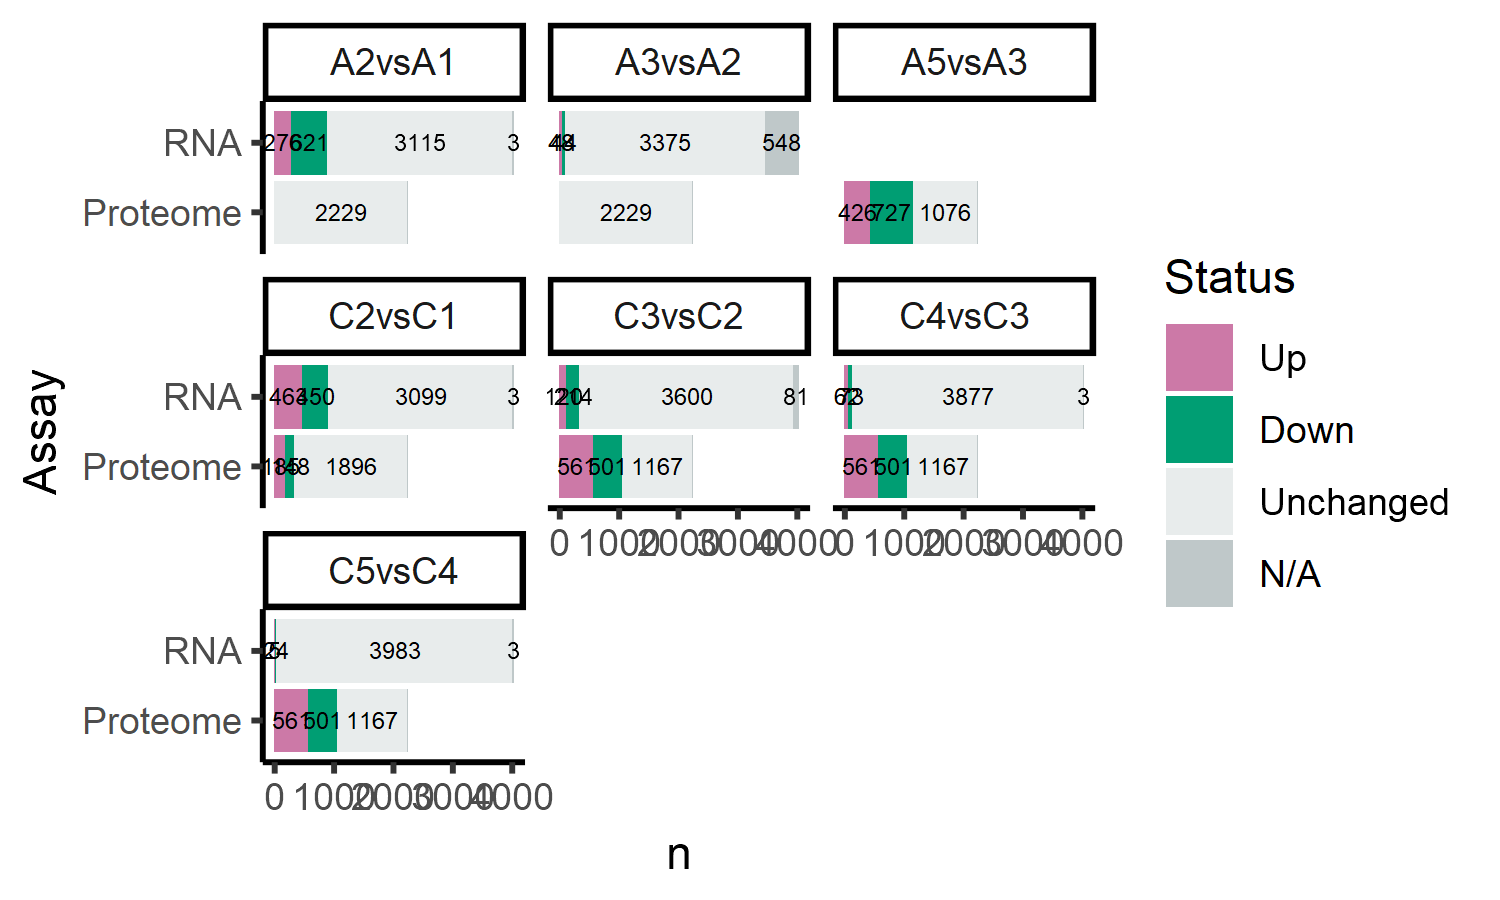

In [63]:
ggplot(mdf_de_stats %>% filter(comparison != 'other'), aes(y = Assay, x = n, fill = Status)) +
  geom_col(position = position_stack(reverse = TRUE)) +
  scale_fill_manual(values = status_palette) +
 
  geom_text(
    aes(label = ifelse(n < 3, NA, n)),
    position = position_stack(reverse = TRUE, vjust = 0.5),
   # check_overlap = TRUE,
      size=2,
  ) +
    facet_wrap(~comparison, ncol = 3) +
    theme_classic()
  #labs(title = "Stacked Bar Chart with Labels")
ggsave('figures/HOT1A3_degenes_bars.svg', height = 3, width = 5)

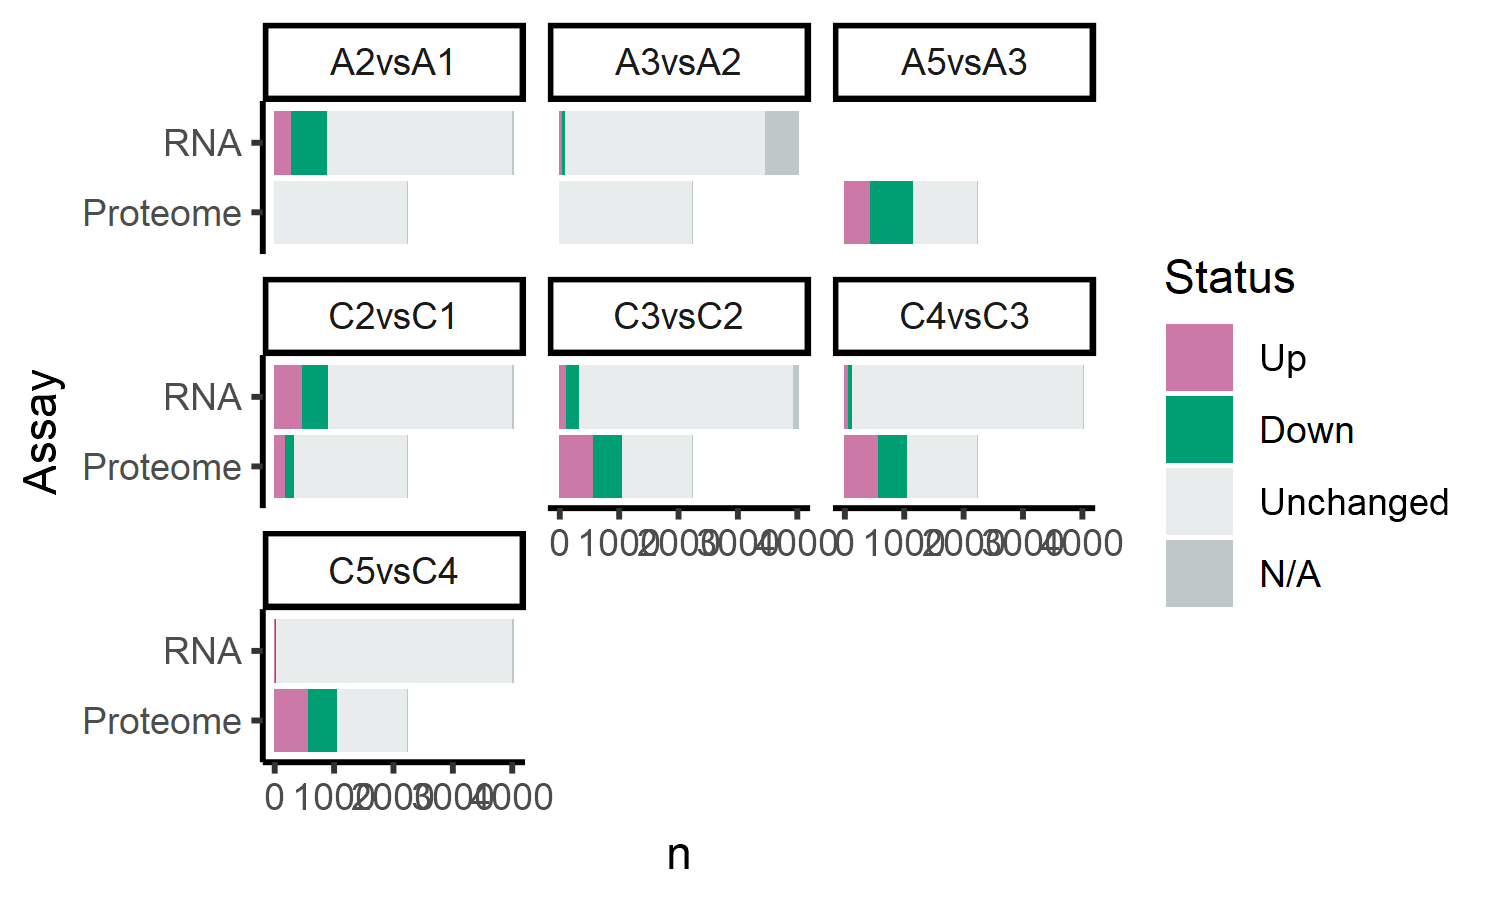

In [64]:
ggplot(mdf_de_stats %>% filter(comparison != 'other'), aes(y = Assay, x = n, fill = Status)) +
  geom_col(position = position_stack(reverse = TRUE)) +
  scale_fill_manual(values = status_palette) +
 
  # geom_text(
  #   aes(label = ifelse(n < 3, NA, n)),
  #   position = position_stack(reverse = TRUE, vjust = 0.5),
  #  # check_overlap = TRUE,
  #     size=2,
  # ) +
    facet_wrap(~comparison, ncol = 3) +
    theme_classic()
  #labs(title = "Stacked Bar Chart with Labels")
ggsave('figures/HOT1A3_degenes_bars_notext.svg', height = 3, width = 5)

In [65]:
dput(unique(mdf_de_stats$comparison))

c("A2vsA1", "other", "A3vsA2", "A5vsA3", "C2vsC1", "C3vsC2", 
"C4vsC3", "C5vsC4")


In [66]:
mdf_de_stats %>% filter(comparison != 'other') %>% count(comparison, contrast1)

Assay,comparison,contrast1,n
<chr>,<chr>,<chr>,<int>
Proteome,A2vsA1,A2vsA1_prot,4
Proteome,A3vsA2,A3vsA2_prot,4
Proteome,A5vsA3,A5vsA3_prot,4
Proteome,C2vsC1,C2vsC1_prot,4
Proteome,C3vsC2,C3vsC2_prot,4
Proteome,C4vsC3,C4vsC3_prot,4
Proteome,C5vsC4,C5vsC4_prot,4
RNA,A2vsA1,A2vsA1_rna,4
RNA,A3vsA2,A3vsA2_rna,4


In [67]:
unique(df_all_orig$Category)

[1] "AA/Nucleotide;Energy/Carbohydrate/Glycan"
 [2] "Other"                                   
 [3] "Energy/Carbohydrate/Glycan"              
 [4] "Nitrogen metabolism"                     
 [5] "Metabolism"                              
 [6] "Membrane transport"                      
 [7] "AA/Nucleotide"                           
 [8] "Env. Info/Cellular Process"              
 [9] "Uncharacterized"                         
[10] "Genetic Info"                            
[11] "Motility"                                
[12] NA

In [68]:
help(theme_classic)

ggtheme {ggplot2},R Documentation
base_size,"base font size, given in pts."
base_family,base font family
base_line_size,base size for line elements
base_rect_size,base size for rect elements
